In [3]:
import numpy as np
import pandas as pd
import zipfile
import plotly.express as px
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import streamlit as st

In [8]:
df = pd.read_csv("housing_clean_data.csv")
st.sidebar.header("Filters")

# Price Range Slider
price_range = st.sidebar.slider("Price Range", 
                                 min_value=int(df["Price"].min()), 
                                 max_value=int(df["Price"].max()), 
                                 value=(int(df["Price"].min()), int(df["Price"].max())))

# City Dropdown
cities = st.sidebar.multiselect("Select Cities", options=df["City"].unique(), default=df["City"].unique())

# Bedrooms and Bathrooms
min_beds, max_beds = st.sidebar.slider(
    "Number of Bedrooms", 
    int(df["Beds"].min()), 
    int(df["Beds"].max()), 
    (int(df["Beds"].min()), int(df["Beds"].max()))
)
min_baths, max_baths = st.sidebar.slider(
    "Number of Bathrooms", 
    int(df["Baths"].min()), 
    int(df["Baths"].max()), 
    (int(df["Baths"].min()), int(df["Baths"].max()))
)

# Square Footage
sqft_range = st.sidebar.slider("Square Footage", 
                                min_value=int(df["Square Feet"].min()), 
                                max_value=int(df["Square Feet"].max()), 
                                value=(int(df["Square Feet"].min()), int(df["Square Feet"].max())))

In [9]:
filtered_data = df[
    (df["Price"] >= price_range[0]) & 
    (df["Price"] <= price_range[1]) &
    (df["City"].isin(cities)) &
    (df["Beds"] >= min_beds) & 
    (df["Beds"] <= max_beds) &
    (df["Baths"] >= min_baths) & 
    (df["Baths"] <= max_baths) &
    (df["Square Feet"] >= sqft_range[0]) & 
    (df["Square Feet"] <= sqft_range[1])
]


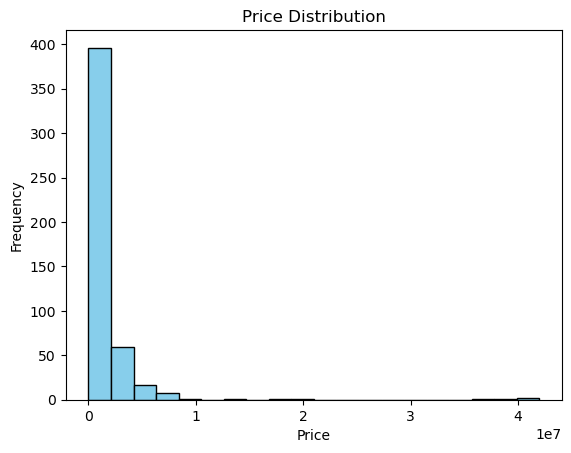

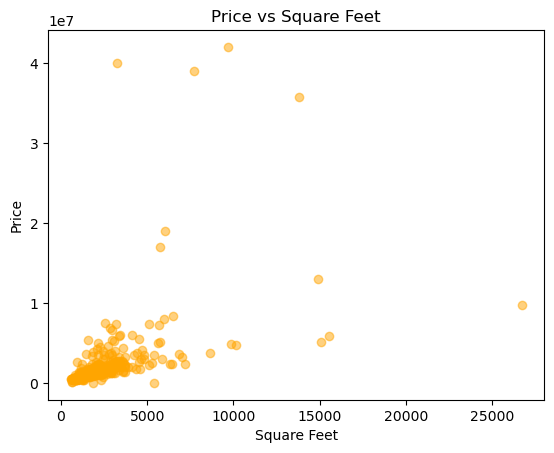

In [10]:
tab1, tab2, tab3 = st.tabs(["Overview", "Visualizations", "Table View"])

# Overview
with tab1:
    st.subheader("Summary Statistics")
    st.write(f"Average Price: ${filtered_data['Price'].mean():,.2f}")
    st.write(f"Average Square Footage: {filtered_data['Square Feet'].mean():,.0f}")
    st.write(f"Average Bedrooms: {filtered_data['Beds'].mean():.1f}")
    st.write(f"Average Bathrooms: {filtered_data['Baths'].mean():.1f}")

# Visualizations
with tab2:
    st.subheader("Visualizations")

    # Price Distribution
    st.write("### Price Distribution")
    fig, ax = plt.subplots()
    ax.hist(filtered_data["Price"], bins=20, color="skyblue", edgecolor="black")
    ax.set_title("Price Distribution")
    ax.set_xlabel("Price")
    ax.set_ylabel("Frequency")
    st.pyplot(fig)

    # Scatter Plot
    st.write("### Price vs Square Feet")
    fig, ax = plt.subplots()
    ax.scatter(filtered_data["Square Feet"], filtered_data["Price"], alpha=0.5, c="orange")
    ax.set_title("Price vs Square Feet")
    ax.set_xlabel("Square Feet")
    ax.set_ylabel("Price")
    st.pyplot(fig)

# Table View
with tab3:
    st.subheader("Filtered Data")
    st.dataframe(filtered_data)
    st.download_button(
        label="Download Filtered Data",
        data=filtered_data.to_csv(index=False),
        file_name="filtered_housing_data.csv",
        mime="text/csv",
    )

In [13]:
def format_city_names(cities):
    if not cities:
        return "All Cities"
    elif len(cities) == 1:
        return cities[0]
    elif len(cities) == 2:
        return f"{cities[0]} & {cities[1]}"
    else:
        return f"{', '.join(cities[:-1])} & {cities[-1]}"

# Generate dynamic city names
city_names = format_city_names(cities)
with tab2:
    st.subheader(f"Visualizations for {city_names}:")

    if filtered_data.empty:
        st.write("No data available for the selected filters.")
    else:
        # Price Distribution (Histogram with Hover)
        st.write("### Price Distribution")
        fig = px.histogram(
            filtered_data,
            x="Price",
            nbins=20,
            title="Price Distribution",
            labels={"Price": "Price"},
            color_discrete_sequence=["skyblue"],
        )
        fig.update_traces(hovertemplate="Price: %{x}<br>Frequency: %{y}")
        st.plotly_chart(fig)

        # Scatter Plot (Interactive Hover)
        st.write("### Price vs Square Feet")
        fig = px.scatter(
            filtered_data,
            x="Square Feet",
            y="Price",
            title="Price vs Square Feet",
            labels={"Square Feet": "Square Feet", "Price": "Price"},
            hover_data=["Address", "Beds", "Baths"],  # Add extra hover information
        )
        st.plotly_chart(fig)

In [14]:
import pydeck as pdk

if "Latitude" in filtered_data.columns and "Longitude" in filtered_data.columns:
    st.write("### Properties on Map")
    map_data = filtered_data[["Latitude", "Longitude", "Price", "Beds", "Bath"]]
    map_layer = pdk.Layer(
        "ScatterplotLayer",
        data=map_data,
        get_position=["Longitude", "Latitude"],
        get_radius=100,
        get_color=[200, 30, 0, 160],
        pickable=True,
    )
    view_state = pdk.ViewState(
        latitude=map_data["Latitude"].mean(),
        longitude=map_data["Longitude"].mean(),
        zoom=10,
        pitch=50,
    )
    r = pdk.Deck(layers=[map_layer], initial_view_state=view_state, tooltip={"text": "{Price}"})
    st.pydeck_chart(r)


In [15]:
from geopy.geocoders import Nominatim
import pandas as pd
import time

geolocator = Nominatim(user_agent="geoapi")

# Function to geocode an address
def geocode_address(address):
    try:
        location = geolocator.geocode(address)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except:
        return None, None

# Add Latitude and Longitude columns
df["Latitude"], df["Longitude"] = zip(*df["Address"].apply(lambda x: geocode_address(x) if pd.notnull(x) else (None, None)))

# Save the updated dataset
df.to_csv("housing_with_coordinates.csv", index=False)

In [16]:
import pandas as pd
import plotly.express as px
import streamlit as st

# Load the dataset with Latitude, Longitude, and Price
df = pd.read_csv("housing_with_coordinates.csv")

# Filter data to ensure valid latitude, longitude, and price
df = df.dropna(subset=["Latitude", "Longitude", "Price"])

# Create a heatmap using Plotly
st.write("### Pricing Heatmap")
fig = px.density_mapbox(
    df,
    lat="Latitude",
    lon="Longitude",
    z="Price",
    radius=10,  # Adjust radius for density calculation
    center=dict(lat=df["Latitude"].mean(), lon=df["Longitude"].mean()),
    zoom=10,
    mapbox_style="carto-positron",  # Map style (change as needed)
    title="Price Heatmap",
)

# Display the Plotly map in Streamlit
st.plotly_chart(fig)


DeltaGenerator()